<h1 align = 'center'><u>STAT40800 Data Programming with Python</u> </h1>
<h1 align = 'center'><u> Ireland Census Data Analysis</u> </h1>
<h3 align = 'center'> Vinutha Shivakumar</h3>

## Introduction


In this project we will be analyzing the 2016 survey data collected by the Central Statistics Office of Ireland at local and county level. This census takes place every five years. The goal of this census is to collect information about the entire population residing in the country when the survey is performed. The census form is delivered to every household, hotels, guesthouses, hospitals and ships to collect the data. The form usually asks questions about their age, sex, marital ststus, education, occupation, religion etc. 

The results of this survey is then used by the government to provide public services to the population. It is used to plan the infrastructure of the city/ county/ local area, provide better health care, transport, housing and education services.

The census data is divided into fifteen themes, each one giving different insight into an aspect of the society. Some of the themes involved are : Types of families, Education, Housing, Industries where majority people work etc. Each of these themes further have numeric counts describing how many people fall under each subcategory within the theme.

The themes that I will be analyzing from this census data are:

1. Education - This theme focuses on the education level and results of this education. The data gives insights about the population above the age 15  and have completed their education further classified by their sex,  population above 15 and who are still pursuing their education further classified by sex, what is the field of study pursued and finally the highest level of education completed.

2. Commuting - In this theme there is data about the mode of transportation used by people going to work / college/ school. Time at which they leavel home for work/ school/ college and what is the journey time. 

Inisghts that I will be checking in these themes:

1. Which field of study is popular in Ireland
2. Is there a trend in number of students at different level of education in different counties
3. What is the most preferred way of commuting to school/work/college
4. Determine how long a student spends commuting to school/college based on the student popluation in a particular area and how they generally travel to their school/college


## Data Cleansing / Pre-Processing

Loading necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,  roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

Reading data into panda dataframe

In [2]:
# Using thousands parameter to deal with the , in the numeric value
# uploading county level data
df_county = pd.read_csv(r'C:\Users\GSVin\OneDrive\Documents\UCD21-22\Autumn\Python\Final_Project\Census_by_County.csv', 
                       thousands = ",")
# uploading electoral area level data
df_electoral_area = pd.read_csv(r'C:\Users\GSVin\OneDrive\Documents\UCD21-22\Autumn\Python\Final_Project\Census_by_electoral_area.csv',
                               thousands = ",")

In [3]:
df_county.head(3)

,GUID,GEOGID,GEOGDESC,T1_1AGE0M,T1_1AGE1M,T1_1AGE2M,T1_1AGE3M,T1_1AGE4M,T1_1AGE5M,T1_1AGE6M,...,T15_1_TC,T15_2_Y,T15_2_N,T15_2_NS,T15_2_T,T15_3_B,T15_3_OTH,T15_3_N,T15_3_NS,T15_3_T
0,EB9428B8-B443-407E-977B-9393FD73E1D0,CTY31_CC,Cork City,720,614,613,645,602,643,647,...,49370,30466,16572,2332,49370,34240,2709,10278,2143,49370
1,84B85B58-010E-45DB-BC55-E137BBE627E4,CTY31_CE,Clare,762,759,780,842,868,843,929,...,43348,29214,12886,1248,43348,27941,4701,9524,1182,43348
2,8A998E65-D3BE-4620-98DE-EBF44DE0285B,CTY31_CK,Cork County,2957,3154,3174,3324,3365,3579,3628,...,146052,103617,38632,3803,146052,103761,12597,26278,3416,146052


Checking for duplicate entries in the county and electoral area level data. We need unique entries in the GEODESC field. So that is the field i will be checking for any duplicacy.

In [4]:
df_county['GEOGDESC'].duplicated().any()

False

There is no duplicate data at county level data

In [5]:
df_electoral_area['GEOGDESC'].duplicated().any()

True

There is duplicate data in electoral area data. Next step is to display the data that has this duplicacy

In [6]:
df_dup = df_electoral_area[df_electoral_area['GEOGDESC'].duplicated(keep=False)]
df_dup

,GUID,GEOGID,GEOGDESC,T1_1AGE0M,T1_1AGE1M,T1_1AGE2M,T1_1AGE3M,T1_1AGE4M,T1_1AGE5M,T1_1AGE6M,...,T15_1_TC,T15_2_Y,T15_2_N,T15_2_NS,T15_2_T,T15_3_B,T15_3_OTH,T15_3_N,T15_3_NS,T15_3_T
5,2AE196293F6A13A3E055000000000001,LEA2014_006,Athlone,146,141,123,159,163,157,160,...,6901,4669,2070,162,6901,4196,965,1576,164,6901
6,2AE196293F0813A3E055000000000001,LEA2014_007,Athlone,216,207,212,208,213,235,245,...,11358,7373,3526,459,11358,7281,1222,2438,417,11358


There seems to be be two entries for the area Athlone. Further checks on data source indicate there are indeed two  Athlones' but in different counties. The first Athlone belongs to Roscommon and the second Athlone to Westmeath. So this is a case of incorrect labelling of data. So I will just rename the electoral areas by appending the county name each Athlone is present in. This will remove the duplicacy issue.

In [7]:
index = list(df_dup.index)
df_electoral_area.loc[index[0], 'GEOGDESC'] = 'Athlone - Roscommon'
df_electoral_area.loc[index[1], 'GEOGDESC'] = 'Athlone - Westmeath'
# check for duplicacy again
df_electoral_area['GEOGDESC'].duplicated().any()

False

There are no more duplicaates so i will proceed now to splitting data into different dataframes based on themes

As I will be analysing only 2 themes, the next step is to extract the columns corresponding to these themes.

1. Eductaion which has column names starting with T10. Further I'm interested in the table containing data about the field of study, counts of population aged 15 and above who are still studying and another table containing information about the highest level of education completed, hence I need columns beginning with T10_2_, T10_3_ and T10_4_.

2. Commuting which has column names starting with T11. In this theme I'm interested in what mode of transport is being used and what is the journey time, hence I need columns beginning with T11_1 and T11_3.


In [8]:
# county level data
df_education_1 = df_county.filter(regex='GEOGDESC|T10_3')
df_education_2 = df_county.filter(regex='GEOGDESC|T10_2')
df_education_3 = df_county.filter(regex='GEOGDESC|T10_4')
df_commute_1 = df_county.filter(regex='GEOGDESC|T11_1')
df_commute_2 = df_county.filter(regex='GEOGDESC|T11_3')

# electoral area level data
df_e_education_1 = df_electoral_area.filter(regex='GEOGDESC|T10_3')
df_e_education_2 = df_electoral_area.filter(regex='GEOGDESC|T10_2')
df_e_education_3 = df_electoral_area.filter(regex='GEOGDESC|T10_4')
df_e_commute_1 = df_electoral_area.filter(regex='GEOGDESC|T11_1')
df_e_commute_2 = df_electoral_area.filter(regex='GEOGDESC|T11_3')

Now I will be renaming the columns to increase readability, checking for any duplicacy and missing data in each of the dataframes

In [9]:
# Education dataframe data cleansing
# column names to be renamed
colnames_edu_1 = ['County','Males_Teaching', 'Males_Art', 'Males_Humanities', 'Males_Social', 'Males_Science', 'Males_Engg', 
               'Males_Agri', 'Males_Health','Males_Service', 'Males_Other', 'Males_Unstated','Males_Total','Females_Teaching',
               'Females_Art', 'Females_Humanities', 'Females_Social', 'Females_Science', 'Females_Engg',  'Females_Agri', 
               'Females_Health', 'Females_Service', 'Females_Other', 'Females_Unstated', 'Females_Total','Total_Teaching', 
               'Total_Art', 'Total_Humanities', 'Total_Social', 'Total_Science', 'Total_Engg',  'Total_Agri','Total_Health',
               'Total_Service', 'Total_Other', 'Total_Unstated', 'Total']
colnames_edu_2 = ['County', 'Studying']
colnames_edu_3 = ['County','No_Education', 'Primary', 'Lower_Secondary', 'Upper_Secondary', 'Technical', 'Advanced_Certificate',
               'Higher_Certificate', 'Bachelors_Degree', 'Honor_Bachelor_Degree', 'Postgraduate/Diploma', 'Doctorate',
               'Not Stated']

# columns to be deleted
col_edu_del_1 = ['T10_2_SASM', 'T10_2_OTHM', 'T10_2_SASF', 'T10_2_OTHF', 'T10_2_OTHT']
col_edu_del_2 = ['T10_4_NFM', 'T10_4_PM', 'T10_4_LSM', 'T10_4_USM', 'T10_4_TVM', 'T10_4_ACCAM','T10_4_HCM',
               'T10_4_ODNDM', 'T10_4_HDPQM', 'T10_4_PDM', 'T10_4_DM', 'T10_4_NSM', 'T10_4_TM', 'T10_4_NFF',
               'T10_4_PF', 'T10_4_LSF', 'T10_4_USF', 'T10_4_TVF', 'T10_4_ACCAF', 'T10_4_HCF', 'T10_4_ODNDF', 
               'T10_4_HDPQF', 'T10_4_PDF', 'T10_4_DF', 'T10_4_NSF', 'T10_4_TF', 'T10_4_TT']

# Dropping columns not required for analysis from the second table of education
df_education_2 = df_education_2.drop(col_edu_del_1, axis=1)
df_education_3 = df_education_3.drop(col_edu_del_2, axis=1)
# df_education_1 contains data about the field of study further sub divided by sex
df_education_1.columns = colnames_edu_1
# df_education_2 contains data about number of people aged 15 and above that are still studying
df_education_2.columns = colnames_edu_2
# df_education_3 contains data about the highest level of education completed
df_education_3.columns = colnames_edu_3
# check if there are any blank values
print(df_education_1.isnull().values.any())
print(df_education_2.isnull().values.any())
print(df_education_3.isnull().values.any())

False
False
False


In [10]:
# Commute dataframe data cleansing
# column names to be renamed
colnames_comm_1 = ['County', 'School_OnFoot', 'School_Cycle', 'School_Bus', 'School_Train', 'School_Motorcycle', 
                   'School_CarDrive', 'School_CarPassenger', 'School_Van', 'School_Home', 'School_Other', 
                   'School_NotStated']
colnames_comm_2 = ['County', 'Under15', '15-30', '30-45', '45-1', '1-1.5', '>1.5', 'NotStated']
# columns to be deleted
col_comm_del_1 = ['T11_1_FW', 'T11_1_BIW', 'T11_1_BUW', 'T11_1_TDLW', 'T11_1_MW', 'T11_1_CDW', 'T11_1_CPW', 'T11_1_VW',
                  'T11_1_OTHW', 'T11_1_WMFHW', 'T11_1_NSW', 'T11_1_TW', 'T11_1_TW', 'T11_1_TS', 'T11_1_FT', 'T11_1_BIT', 
                  'T11_1_BUT', 'T11_1_TDLT', 'T11_1_MT', 'T11_1_CDT', 'T11_1_CPT', 'T11_1_VT', 'T11_1_OTHT', 'T11_1_WMFHT',
                  'T11_1_NST', 'T11_1_TT']
col_comm_del_2 = ['T11_3_T']
# Dropping columns not required for analysis
df_commute_1 = df_commute_1.drop(col_comm_del_1, axis=1)
df_commute_2 = df_commute_2.drop(col_comm_del_2, axis=1)
# df_commute_1 has data about mode of transportation used for getting to work/school/college
df_commute_1.columns = colnames_comm_1
# df_commute_2 has data about how long one spends commuting to school/work
df_commute_2.columns = colnames_comm_2
# check if there are any blank values
print(df_commute_1.isnull().values.any())
print(df_commute_2.isnull().values.any())

False
False


There are no null / blank values in any of the dataframes

Performing the same data cleansing steps for electoral area data.

In [11]:
# Education dataframe data cleansing at electoral area level
# Dropping columns not required for analysis from the second table of education
# Dropping columns not required for analysis from the second table of education
df_e_education_2 = df_e_education_2.drop(col_edu_del_1, axis=1)
df_e_education_3 = df_e_education_3.drop(col_edu_del_2, axis=1)
# df_education_1 contains data about the field of study further sub divided by sex
df_e_education_1.columns = colnames_edu_1
# df_education_2 contains data about number of people aged 15 and above that are still studying
df_e_education_2.columns = colnames_edu_2
# df_education_3 contains data about the highest level of education completed
df_e_education_3.columns = colnames_edu_3
# check for duplicates
print('Any duplicates present? ',df_e_education_1['County'].duplicated().values.any())
# check if there are any blank values
print('Nulls in df_e_education_1? ',df_e_education_1.isnull().values.any())
print('Nulls in df_e_education_2? ',df_e_education_2.isnull().values.any())

# Commute dataframe data cleansing at electoral area level
# Dropping columns not required for analysis
df_e_commute_1 = df_e_commute_1.drop(col_comm_del_1, axis=1)
df_e_commute_2 = df_e_commute_2.drop(col_comm_del_2, axis=1)
# df_e_commute_1 has data about mode of transportation used for getting to work/school/college
df_e_commute_1.columns = colnames_comm_1
# df_e_commute_2 has data about how long one spends commuting to school/work
df_e_commute_2.columns = colnames_comm_2
# check if there are any blank values
print('Nulls in df_e_commute_1? ', df_e_commute_1.isnull().values.any())
print('Nulls in df_e_commute_2? ',df_e_commute_2.isnull().values.any())

Any duplicates present?  False
Nulls in df_e_education_1?  False
Nulls in df_e_education_2?  False
Nulls in df_e_commute_1?  False
Nulls in df_e_commute_2?  False


There are no null entries in any of the dataframe so no action needs to be taken.

## Exploratory Data Analysis

### Education theme analysis

-  Analysing male vs female eductaion level across different counties

We have total columns for both male and female category aged 15 and above in the df_education_1 table. I want to check the overall distribution of male and female population pursuing studies.

In [12]:
df_education_1[['Males_Total', 'Females_Total']].describe()

,Males_Total,Females_Total
count,31.000000,31.000000
mean,48831.741935,51073.161290
std,35897.656053,38213.430181
min,10784.000000,10800.000000
25%,24845.000000,25540.000000
50%,40673.000000,42923.000000
75%,58775.500000,60326.000000
max,185165.000000,195589.000000


Overall there is slightly more number of women pursuing studies compared to men. There is just a small difference of over 2000 people. So I would conclude that there is similar distribution between number of men and women pursuing their studies.

-  Student population distribution across different counties

Next I wanted to see which County has the most number of people pursuing their studies. This of course is a function of population in the given county too. But in this case I'm just curious about which county has more number of people studying because this is an indicative to government / other types of analysts about measures needed to provide the desired level of infrastructure to accomodate the growing number of students.

Text(0.5, 1.0, 'Total Number of people educated in each County')

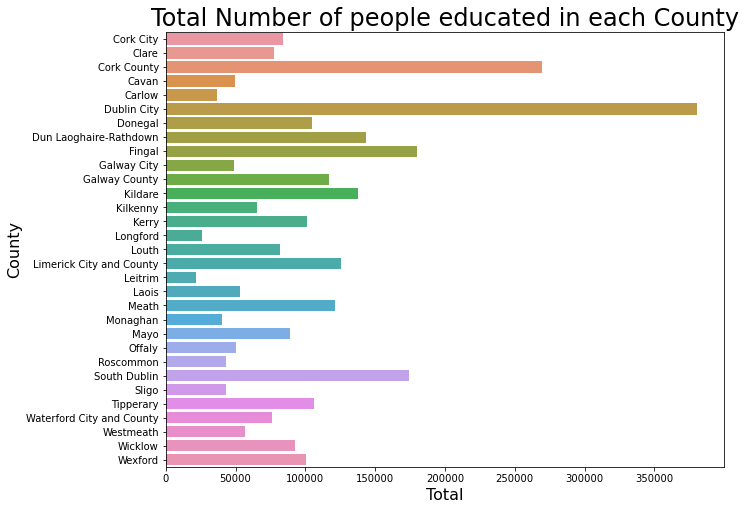

In [13]:
plt.figure(figsize=(10,8))
bplot1 = sns.barplot(x='Total', y='County', data=df_education_1)
plt.xlabel("Total", size=16)
plt.ylabel("County", size=16)
plt.title("Total Number of people educated in each County", size=24)

From the barplot its evident that there a lot of students pursuing their education at different levels in County Dublin and County Cork. Similarly Leitrim and Longford counties has the least number of student population

- Field of study that is popular

Further analysing which field of study is most popular in the counties Dublin and Cork with a big student population and counties with much lower counts like Leitrim and Longford.

In [14]:
#fetch rows containing information about the counties of interest
df_education_field = df_education_1.loc[df_education_1['County'].isin(['Leitrim', 'Longford', 
                                                                       'Dublin City', 'Cork County'])]
# using columns that are indicative of different fields of study
df_education_field[['Total_Teaching', 'Total_Art', 'Total_Humanities', 'Total_Social', 
                    'Total_Science', 'Total_Engg',  'Total_Agri','Total_Health',
               'Total_Service']].idxmax(axis=1)

2     Total_Social
5     Total_Social
14    Total_Social
17    Total_Social
dtype: object

It looks like the field of Social Sciences, Business and law is popular across these four counties.

Now I want to check if this is the same choice of field when i look into the male and female data specifically.

In [15]:
# poular field of education for males
df_education_field[['Males_Teaching', 'Males_Art', 'Males_Humanities', 'Males_Social', 'Males_Science', 'Males_Engg', 
               'Males_Agri', 'Males_Health','Males_Service']].idxmax(axis=1)

2       Males_Engg
5     Males_Social
14      Males_Engg
17      Males_Engg
dtype: object

The field of Engineering, Manufacturing and construction is more popular among the male population in Cork, Leitrim and Longford. In Dublin alone there is a focus on the Social Sciences field amongst men.

In [16]:
# popular field of education for females
df_education_field[['Females_Teaching', 'Females_Art', 'Females_Humanities', 'Females_Social', 'Females_Science', 
                    'Females_Engg',  'Females_Agri', 'Females_Health', 'Females_Service']].idxmax(axis=1)

2     Females_Social
5     Females_Social
14    Females_Social
17    Females_Social
dtype: object

The female population is more interested in the Social Science fields across all the four counties.

-  Trend in different level of education

Observing if there is a trend in the number of people who are uneducated, in their primary level of education and other higher levels of education in the four counties Dublin, Cork, Leitrim and Longford.

Text(0, 0.5, 'Count')

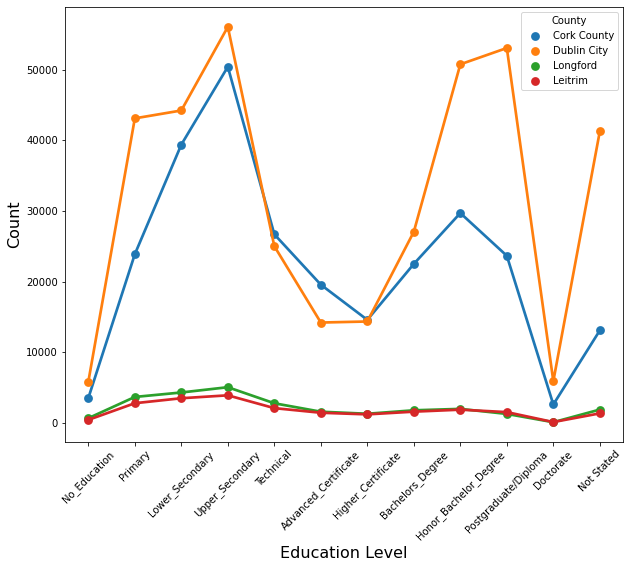

In [17]:
# fetch rows containng data of the counties of interest
df_ed_3 =  df_education_3.loc[df_education_3['County'].isin(['Leitrim', 'Longford', 
                                                            'Dublin City', 'Cork County'])]
# using data melt to change structure of dataframe to build a plot
df_ed_3_melt = df_ed_3.melt('County', var_name='ed_level', value_name='count')
plt.figure(figsize=(10,8))
plt2 = sns.pointplot(x='ed_level', y='count', hue='County', data=df_ed_3_melt )
plt2.set_xticklabels(plt2.get_xticklabels(),rotation = 45)
plt.xlabel("Education Level", size=16)
plt.ylabel("Count", size=16)

1. The number of people that are uneducated remain low across all counties.
2. Leitrim and Longford show similar trends in education levels. Both counties have a student population in Primary - Upper secondary level of education. Beyond this there is a decline in number of students pursuing higher levels of education. This could be due to lower education options available in these counties and students moving elsewhere to pursue higher studies.
3. Dublin City has a big number of student population in Upper Secondary level and Postgraduate studies. Dublin does appear to be a popular destination for higher studies for students.
4. Cork County also shows a similar trend but with a much lower count compared to Dublin. Other than upper secondary students there is a higher number of students pursuing Honours Bachelor degree.
5. As we are looking into an age group of 15 years and above it explains why there is more number of students in the Primary - Upper Secondary levels of education. They represent the bulk of population in their initial levels of education.
6. Number of people pursuing their doctorates is low across all these counties. This level of education is clearly not popular in these counties or there could be a lack of infrastructure to support the doctorate students needs and they are moving elsewhere to complete their doctorate degrees.

### Commute theme analysis

- Preferred mode of travelling

In the commute theme I have mainly picked columns assosciated with students and how they commute to school/college. I will continue analysis on the four counties as before(Dublin, Cork, Leitrim and Longford)

The first question I would like to address is what is the preferred mode of transportaion when it comes to students.

Text(26.445772569444443, 0.5, 'Count')

<Figure size 720x576 with 0 Axes>

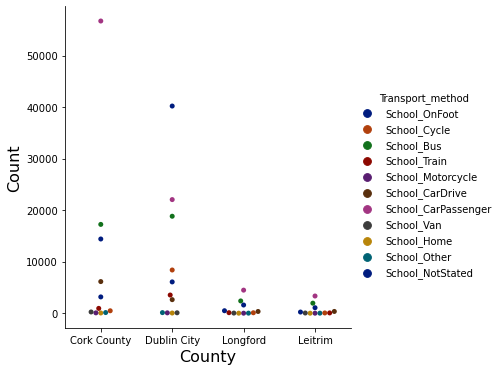

In [18]:
#fetch rows containing data of the counties of interest
df_comm_1 = df_commute_1[df_commute_1['County'].isin(['Leitrim', 'Longford', 
                                                    'Dublin City', 'Cork County'])]
# using data melt to transform data for plotting
df_comm_melt = df_comm_1.melt('County', var_name='Transport_method', value_name='count')
plt.figure(figsize=(10,8))
plt2 = sns.catplot(x='County', y='count', hue='Transport_method', kind="swarm", data=df_comm_melt,
                  palette='dark')
plt.xlabel("County", size=16)
plt.ylabel("Count", size=16)

1. In Cork , Leitrim and Longford County majority of student population travel by car as a passsenger to either college / school.
2. In Dublin walking is the choice of transport to get to school / college followed by travelling in a car as a passenger.
3. The mode of transport travelling by car as a passenger is quite popular as we have a bulk of student population at their schooling level and they usually have their parents dropping them of to school / college. It also acts a means to get to school/ college faster
4. Walking is the next most popular mode of transport as its free. Its more popluar when the school/college is within walking distance from the place the student lives.
5. Other modes of transportation like cycle, bus, train, motorcycle and cars are used but not popluar because of the cost factor. Cycling is popluar in Dublin but not so much in other counties taking into account the weather conditions and the maintenance cost that goes into the upkeep of a cycle and to some extent cycle theft which is quite common in Ireland.

- Time spent travelling

This table contains the amount of time spent by the general popluation to get to work, school or college. So this analysis is combination of both working and student professional and a much larger age group( 5 and above). We could still see how much time is spent travelling. It could be indicative of how efficeint the transport system is in the county, status of roads for people driving, cycling and footpaths for popluation walking to work/school.

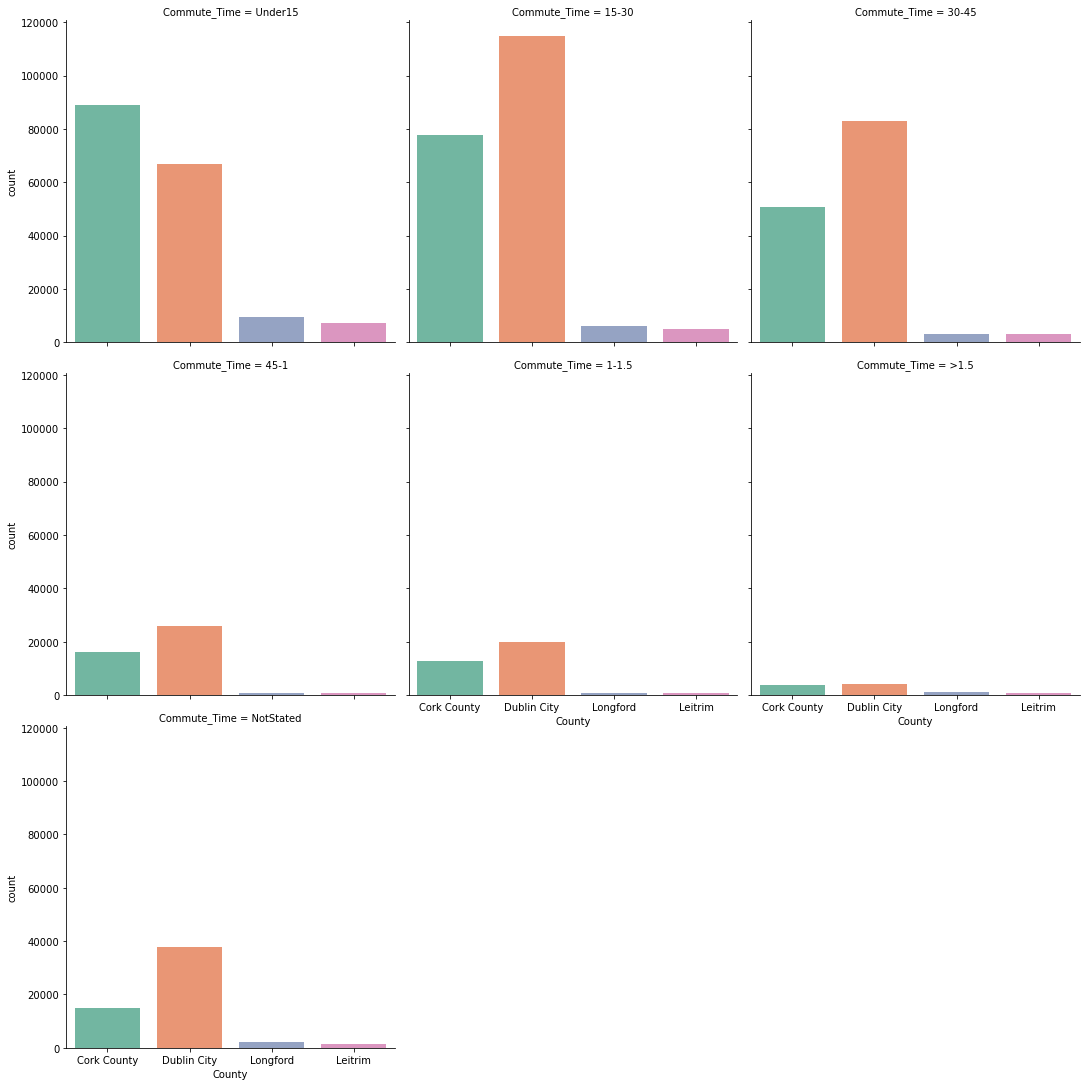

In [19]:
# fetching rows containing data of counties of interest
df_comm_2 = df_commute_2[df_commute_2['County'].isin(['Leitrim', 'Longford', 
                                                    'Dublin City', 'Cork County'])]
df_comm_2_melt = df_comm_2.melt('County', var_name='Commute_Time', value_name='count')
sns.catplot(x='County', col='Commute_Time', col_wrap=3, data=df_comm_2_melt,
           kind='bar', y='count', palette='Set2')

1. Looking at these distributions we can see that in general people spend anytime under 15 to under 30 minutes travelling to work or to school.
2. The time spent travelling is a function of how many people use their own mode of transportation to get to work/school i.e., cars, motorcycles etc vs usage of public transport. If there are more number of people using their own mode of transport this could lead to more road traffic and thereby increase the time spent travelling.
3. The distance also plays into a huge factor to time spent travelling. The trend above suggest that people usually go to school/college near them or live in a space close to work. 
4. The proportion of popluation that spends time travelling greater than 1 hour is quite low across all these counties.
5. These counties have an efficient transport system as a bulk of popluation spends lass than 45 minutes commuting.

So far the analysis of commute time has been on the bulk of poluation. I would like to further analyse the commute time of the student popluation aged 15 and above. For this purpose i will be combining dataframes of the education and commute theme. Also
for the purpose of building a good prediction model i will now start using the electoral area level data as it has more datapoints available for training and testing purpose. Moving to the electoral area is good for my analysis as from the above analysis we know people generally live close to school / place of work. So having information about the transport system at the electoral area level gives us a better picture about its student popluation and how they are travelling to school/work and how this is going to affect the commute time.

In [20]:
# using merge function on county to combine different dataframes
# df_e_education_2 just has a count of number of people aged 15 and above that are still studying
# df_e_commute_1 has the  count distribution of different modes of transport
# df_e_commute_2 has the commute time info
df_edu_transport = pd.merge(df_e_education_2, df_e_commute_1, on='County')
df_final = pd.merge(df_edu_transport, df_e_commute_2, on='County')
# renaming the column from county to electoral area to avoid any confusion
df_final = df_final.rename(columns={'County': 'Electoral_area'})
# checking the datatypes of these columns
df_final.dtypes

Electoral_area         object
Studying                int64
School_OnFoot           int64
School_Cycle            int64
School_Bus              int64
School_Train            int64
School_Motorcycle       int64
School_CarDrive         int64
School_CarPassenger     int64
School_Van              int64
School_Home             int64
School_Other            int64
School_NotStated        int64
Under15                 int64
15-30                   int64
30-45                   int64
45-1                    int64
1-1.5                   int64
>1.5                    int64
NotStated               int64
dtype: object

We are dealing with a majority of numerical data only the county column is categorical.

## Statistical Analysis

First step is to transform the commute time counts to represent the student population aged 15 and above. As this is the population proportion we are interested in.

In [21]:
# transforming the commute-time count to denote the student proportion
df_final['Under15'] = df_final['Under15']/df_final['Studying']
df_final['15-30'] = df_final['15-30']/df_final['Studying']
df_final['30-45'] = df_final['30-45']/df_final['Studying']
df_final['45-1'] = df_final['45-1']/df_final['Studying']
df_final['1-1.5'] = df_final['1-1.5']/df_final['Studying']
df_final['>1.5'] = df_final['>1.5']/df_final['Studying']

1. Using Label Encorder to convert categorical to numeric datatypes. Here i use this on the Electoral area column just to make model building easier.
2. Normalizing data of all dataframes at county and electoral area level for further analysis to remove any kind of bias that might get created and help build a more accurate model. I will be using Min-Max scaler to perform this transformation. The data we get will be in the range [0,1]

In [22]:
df_final_std = pd.DataFrame()
df_final_std['Electoral_area'] = df_final['Electoral_area']
# define label encoder
labelencoder = LabelEncoder()
df_final_std['Electoral_area_cat'] = labelencoder.fit_transform(df_final['Electoral_area'])
# getting all columns that need to be normalized
df_final_col = list(df_final.columns)
# removing electoral area as its categorical
df_final_col.remove("Electoral_area")
# define min max scaler
scaler = MinMaxScaler()
df_final_std[df_final_col] = scaler.fit_transform(df_final[df_final_col])
# dropping columns that arent useful
df_final_std = df_final_std.drop(['School_NotStated', 'NotStated'], axis=1)
df_final_std.head()

,Electoral_area,Electoral_area_cat,Studying,School_OnFoot,School_Cycle,School_Bus,School_Train,School_Motorcycle,School_CarDrive,School_CarPassenger,School_Van,School_Home,School_Other,Under15,15-30,30-45,45-1,1-1.5,>1.5
0,Adare - Rathkeale,0,0.246414,0.070554,0.010911,0.279771,0.005517,0.111111,0.383779,0.302188,0.214286,0.000000,0.139535,0.445233,0.613247,0.744569,0.350421,0.147825,0.214192
1,Ardee,1,0.242616,0.143868,0.025674,0.492220,0.008966,0.111111,0.173077,0.267412,0.523810,0.000000,0.279070,0.570218,0.609780,0.524829,0.360379,0.492510,0.671571
2,Arklow,2,0.176371,0.195618,0.010270,0.248968,0.064828,0.185185,0.128763,0.226617,0.190476,0.058824,0.162791,0.683067,0.437363,0.413197,0.464787,0.742163,0.940262
3,Ashbourne,3,0.201406,0.242884,0.052632,0.361385,0.036552,0.222222,0.164716,0.218878,0.309524,0.058824,0.139535,0.567398,0.648606,0.995025,0.815849,0.778624,0.570608
4,Athenry - Oranmore,4,0.313783,0.123512,0.034660,0.449984,0.057241,0.185185,0.313545,0.426961,0.928571,0.235294,0.209302,0.551742,0.796874,0.980904,0.488394,0.245009,0.235678


We have few more steps of data preparation before we can building a model for predicting time spent commuting. We need to create a classifier column in out datarame in order to train a successful binary classifier model.

1. Determine which commute time count is highest and that will be the classification category for the particular row
2. Perform numeric encoding to the new category column which will be used to train our dataset

In [23]:
# determining which is commute time has the largest proportion
# Using the original data for classification purpose as normalization for this step isnt required
df_final_std['classification'] = df_final[['Under15', '15-30', '30-45', '45-1', '1-1.5', '>1.5']].idxmax(axis=1)
df_final_std['classification'].unique()

array(['Under15', '15-30'], dtype=object)

So we get two main categories to build a binary classification model. I will be using Logistic Regression to build a model that will predict whether the commute spent by students aged 15 and above is under 15 minutes or in the 15-30 minutes category.

In [24]:
# converting the category value to numeric value
df_final_std['classification'] = df_final_std['classification'].map({'Under15':1, '15-30':0})

Building a correlation matrix to visualize the relationship between different coluumns

[Text(0.5, 0, 'classification')]

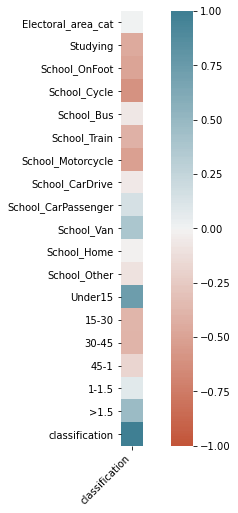

In [25]:
corr = df_final_std.corr()
plt.figure(figsize=(10,8))
corr_plot = sns.heatmap(corr[['classification']], 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
corr_plot.set_xticklabels(
    corr_plot.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

There is some good co-relation between the classifier and the other columns of interest.

1. There is a negative relationship between the classifier and number of students, counts representing how many use train, cycle, car etc. This can easily be understood if thereare more number of students travelling to school/college by any means of transport there is bound to be more traffic and thereby increase the time spent commuting.
2. The columns actually representing the counts of each commute time will be disregarded for model building purpose as that is what im trying to predict.
3. Finally i can use the transport methods and number of students to determine how long a student commutes
4. I will also be removing School_Home as a student being homeschooled doesnt commute and it doesnt in anyway contribute to commute time prediction

- Splitting data into test and train dataset

In [26]:
X_cols = ['Studying', 'School_OnFoot', 'School_Cycle', 'School_Bus', 'School_Train', 'School_Motorcycle', 
          'School_CarDrive', 'School_CarPassenger', 'School_Van', 'School_Other']
X = df_final_std[X_cols]
Y = df_final_std['classification']
# Using a 80-20 test split between train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

- Feature sampling to get the best model

I will be using Recursive Feature Elimination to construct models repeatedly to see which group of features gives me the best performing model

In [27]:
log_reg = LogisticRegression()
rfe = RFE(log_reg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
# the below statement gives a binary output which helps us to decide if we keep or
# reject a feature
print(rfe.support_)
# each of the feature are given a rank 
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


The above result states that we can use all the columns specified in X_cols to get the best model for predicting the commute time. Next step is to fit the model with these features and analyse the result

In [28]:
logreg = LogisticRegression()
# fit the model on training data
logreg.fit(X_train, y_train)
# predict using the test data
y_pred = logreg.predict(X_test)
print("Accuracy of this model : {:.2f}".format(logreg.score(X_test, y_test)))

Accuracy of this model : 0.89


This model gives an accuracy of 89%  accuracy in classifying the commute time. Let us further analyse the confusion matrix to check the sensitivity and specificity of the model.

<AxesSubplot:>

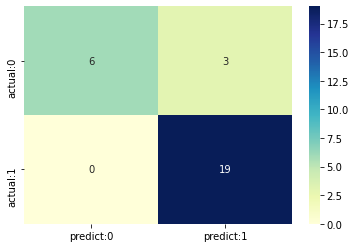

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(data=conf_matrix, columns=['predict:0','predict:1'], index=['actual:0','actual:1'])
sns.heatmap(conf_df, annot=True,fmt='d',cmap="YlGnBu")

The model has predicted some false positives but no false negatives. Next lets determine the sensitivity and the specificity of the model

In [30]:
true_positive = conf_matrix[1,1]
true_negative = conf_matrix[0,0]
false_positive = conf_matrix[0,1]
false_negative = conf_matrix[1,0]
sensitivity = float(true_positive)/(true_positive + false_negative)
specificity = float(true_negative)/(true_negative + false_positive)
print('Sensitivity : ', sensitivity)
print('Specificity : ', specificity)

Sensitivity :  1.0
Specificity :  0.6666666666666666


The sensitivity is very good meaning the model will not incorrectly classify a positive as negative.  The specificity score is 66.6% meaning the model only classify the aforementioned perecentage of positive values correctly.

- ROC Curve

The Receiver operating characteristic curve is used to show the trade off between the specificity and the sensitivity of the model. 

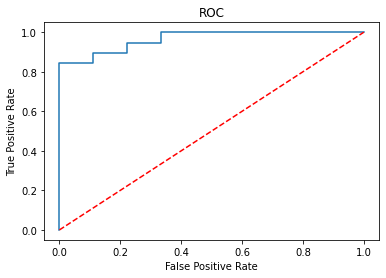

In [31]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

As the curve is far from the dotted red line we can conclude the model performs well.

## Conclusion

Ireland has a substantial population consisting of students at different levels of education. Social Science, Business , Law, Engineering are the most popular fields of study in the country. There is very little gender gap in the population pursuing their education which is great both for the popluation and the country as a whole. Analyzing the number of students at different levels of education showed that majority are in their initial years of schooling. There is a trend that students might move to a bigger county that offers more options for education and has more opportunities. There is also a very small percentage of population pursuing their doctorates in Ireland.

Commuting is a big part of life for anyone. Be it getting to work / school, the mode of transport plays a very important role in determining our commute time. We have seen that travelling in a car as passenger and waking is the most popular means of transport in four of the counties in Ireland. This could be extended to other counties too as we have seen that there is a good amount of students travelling to school/work and they usually have their parents or other dependants dropping them and picking from school/college. Being a student also means being on budget so walking is usually preferred as one doenst have to pay to get to destonation. Other than walking cycling is also quite popular. Public transports are used by students but at a much lower proportion taking cost into consideration. Overall Ireland does have an efficient transport system as majprity og the population spends less than one hour to commute to school/college/work

Next I combined these two themes to determine how long students usually commute. Logistic Regression model built on features like number of students in the electoral area along with the number of students using different types of transport together are used to classify whether its under 15 minutes or in the 15-30 minutes range. The model predicts the commute time with 89% accuracy. The 2016 dataset points to these two ranges as a classifier for all the electoral areas which is great because students arent soending too much time getting to their school/college. It only speaks more to the efficiency of the transport system of Ireland and also the strategic placements of schools and colleges in the area so that very little time is wasted travelling. There is a lot of scope for improvement to this model by changing the thresholds and even a different sampling method for testing and training the data and test this with other algorithms like Random Forest to see if it gives better accuracy. Further in depth analysis could be done to see if there are any more features to make this model more accurate. This model is built as a binary classifier but it can be improved to work as a multi class classification model to work with future datasets where we might get more classes for prediction.